<a href="https://colab.research.google.com/github/Akriti3/Brain_MRI_using_Pytorch/blob/main/Brain_MRI_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"nainajaiswal96","key":"df14fe6f94f1e6389fb9b5ea6c753e5f"}'}

In [ ]:
#create kaggle directory

! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:



!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 98% 697M/714M [00:04<00:00, 160MB/s]
100% 714M/714M [00:04<00:00, 151MB/s]


In [ ]:
!unzip lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [ ]:
    
import glob     # the glob module is used to retrieve files/pathnames matching a specified pattern
import time     #suggests Python time module allows to work with time in Python. It allows functionality like getting the current time, pausing the Program from executing, etc.
import numpy as np   #the library contains a large number of mathematical, algebraic, and transformation functions.
import pandas as pd  #It has functions for analyzing, cleaning, exploring, and manipulating data.
from tqdm import tqdm  #Tqdm is a Python library used to display smart progress bars that show the progress of your Python code execution. This library can also be used to see the progress of a machine learning model while training the model on a very large data set.

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split  #train_test_split is a function in Sklearn model selection for splitting data arrays into two subsets: for training data and for testing data. By default, Sklearn train_test_split will make random partitions for the two subsets.

import torch           # PyTorch is a Python package that provides two high-level features: Tensor computation (like NumPy) with strong GPU acceleration. Deep neural networks built on a tape-based autograd system.
import torch.nn as nn  #The torch. nn import gives us access to some helpful neural network things, such as various neural network layer types (things like regular fully-connected layers, convolutional layers (for imagery), recurrent layers...etc).
import torch.nn.functional as F 
from torchvision import transforms as T #Transforms are common image transformations
import albumentations as A         #Albumentations is a computer vision tool that boosts the performance of deep convolutional neural networks. The library is widely used in industry, deep learning research, machine learning competitions, and open source projects.      

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ROOT_PATH = '/content/lgg-mri-segmentation/kaggle_3m/'

In [ ]:

#Creating DataFrame
mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

In [ ]:

def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})
df.head()

,image_path,mask_path,diagnosis
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1


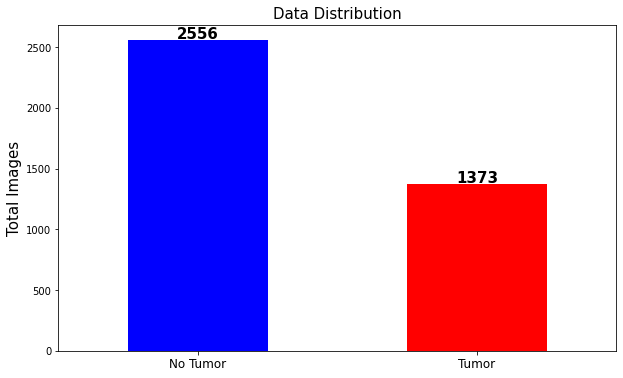

In [ ]:
ax = df['diagnosis'].value_counts().plot(kind='bar', figsize=(10,6), stacked=True, color=['blue', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)



In [ ]:
# Split data into train/validation/test set

train_df, val_df = train_test_split(df, stratify=df['diagnosis'], test_size=0.1)   # Stratified Sampling is a sampling method that reduces the sampling error in cases where the population can be partitioned into subgroups. We perform Stratified Sampling by dividing the population into homogeneous subgroups, called strata, and then applying Simple Random Sampling within each subgroup.
train_df = train_df.reset_index(drop=True)               # We can achieve this by setting the “stratify” argument to the y component of the original dataset. This will be used by the train_test_split() function to ensure that both the train and test sets have the proportion of examples in each class that is present in the provided “y” array.
val_df = val_df.reset_index(drop=True)                   

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15)
train_df = train_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


(-0.5, 2604.5, 520.5, -0.5)

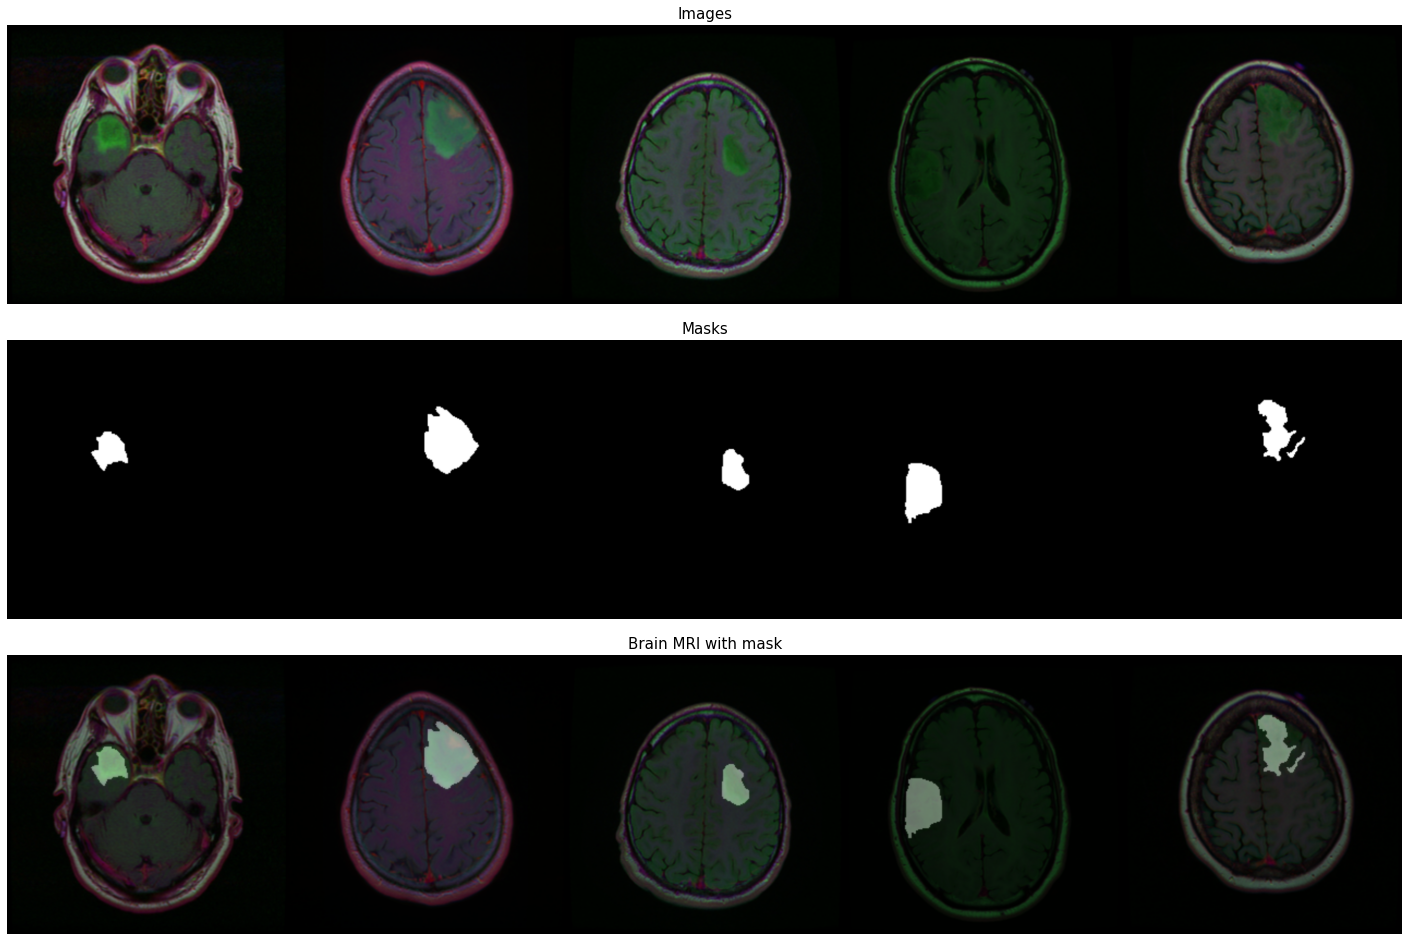

In [ ]:
#Visualize Image with Mask

# If we use UNET then it will pass through a number of different convolutional layers , relu , pooling etc. . It will learn the features of images according to its corresponding masks . It will give the label to objects and then it learns the features of images we pass in its training . It will match the object of image with its corresponding mask to learn the object features only not unnecessary objects features . Like if we pass the image of cat and its background is filled with some unnecessary obstacles(bins , table , chair etc. ) According to the mask of cat , it will learn the features of cats only 
#However not only UNET every segmentation algorithm works in the same way that it will learn to detect the features that are masked and ignoring unnecessary objects
#U-Net is a learning-based neural segmentation algorithm, you need a labeled training set to make this work. It predicts correct class labels for each pixel in the input image. It is a learning-based system and segments based on what you teach it! Also you may not even need 1000 images. UNET uses augmentation during training. 

IMG_SIZE = 521                                  
images = []
masks = []                 
df_positive = df[df['diagnosis']==1].sample(5).values 
for data in df_positive:                              
    img = cv2.resize(cv2.imread(data[0]), (IMG_SIZE, IMG_SIZE)) 
    mask = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    images.append(img)
    masks.append(mask)
images = np.hstack(np.array(images))    #hstack() function is used to stack the sequence of input arrays horizontally (i.e. column wise) to make a single array. 
masks = np.hstack(np.array(masks))      

fig = plt.figure(figsize=(25,25))
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.5)

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')
grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')

In [ ]:
#Data Generator and Augmentation

def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i = 0 
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
        if image is True:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img * std + mean).astype(np.float32)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img); 
        plt.axis('off')
        i += 1
    return plt.show()

In [ ]:

class BrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.
        
        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
            
        image = image.transpose((2,0,1))
        image = torch.from_numpy(image).type(torch.float32)
        image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)
        
        return image, mask
    
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
])
val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
])
test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0)
])

In [ ]:
#Create dataset

train_dataset = BrainDataset(train_df, train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=26, shuffle=True, num_workers=2)

val_dataset = BrainDataset(val_df, val_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=26, shuffle=True, num_workers=2)

test_dataset = BrainDataset(test_df, test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=26, shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([26, 3, 128, 128])
torch.Size([26, 1, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

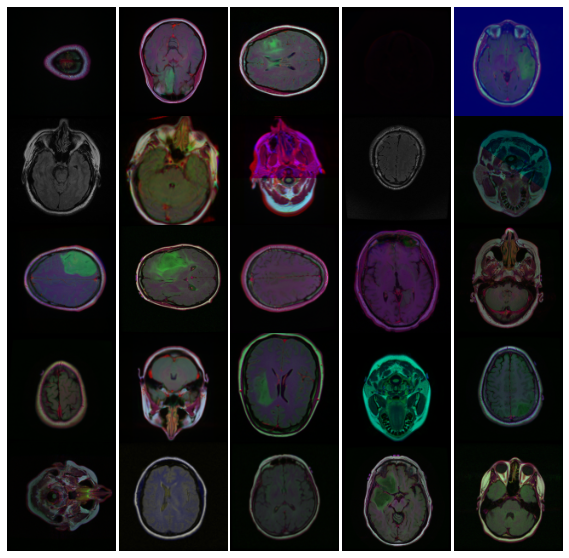

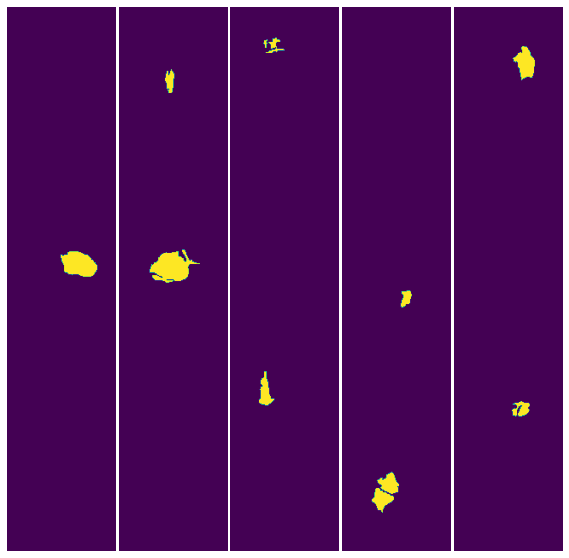

In [ ]:
images, masks = next(iter(train_dataloader))
print(images.shape)
print(masks.shape)
show_aug(images)
show_aug(masks, image=False)

In [ ]:
#Create Model
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)
    
class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,                    # // --> Floor division - division that results into whole number adjusted to the left in the number line
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)        
        self.up3 = Up(256, 128//factor, bilinear)        
        self.up4 = Up(128, 64, bilinear)        
        self.outc = OutConv(64, n_classes)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
model = UNet(3, 1).to(device)
out = model(torch.randn(1, 3, 256, 256).to(device))
print(out.shape)

torch.Size([1, 1, 256, 256])


In [ ]:
# Metric and Loss Function 

def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union
def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)
def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss 
     
     

In [ ]:
# Train Model

def compute_iou(model, loader, threshold=0.3):
    valloss = 0
    with torch.no_grad():
        for step, (data, target) in enumerate(loader):
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            loss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += loss

    return valloss / step

In [ ]:
def train_model(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        losses = []
        train_iou = []
        
        for i, (image, mask) in enumerate(tqdm(train_loader)):
            image = image.to(device)
            mask = mask.to(device)
            outputs = model(image)
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0            
            
            train_dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
            loss = loss_func(outputs, mask)
            losses.append(loss.item())
            train_iou.append(train_dice)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
        val_mean_iou = compute_iou(model, val_loader)
        scheduler.step(val_mean_iou)
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        print('Epoch : {}/{}'.format(epoch+1, num_epochs))
        print('loss: {:.3f} - dice_coef: {:.3f} - val_dice_coef: {:.3f}'.format(np.array(losses).mean(),
                                                                               np.array(train_iou).mean(),
                                                                               val_mean_iou))
    return loss_history, train_history, val_history

In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
num_epochs = 120
loss_history, train_history, val_history = train_model(train_dataloader, val_dataloader, bce_dice_loss, optimizer, scheduler, num_epochs)


100%|██████████| 116/116 [00:55<00:00,  2.11it/s]


Epoch : 1/120
loss: 0.423 - dice_coef: 0.633 - val_dice_coef: 0.628


100%|██████████| 116/116 [00:57<00:00,  2.01it/s]


Epoch : 2/120
loss: 0.406 - dice_coef: 0.642 - val_dice_coef: 0.723


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 3/120
loss: 0.364 - dice_coef: 0.680 - val_dice_coef: 0.767


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 4/120
loss: 0.362 - dice_coef: 0.680 - val_dice_coef: 0.759


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 5/120
loss: 0.334 - dice_coef: 0.705 - val_dice_coef: 0.751


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 6/120
loss: 0.316 - dice_coef: 0.721 - val_dice_coef: 0.745


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 7/120
loss: 0.346 - dice_coef: 0.694 - val_dice_coef: 0.765


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 8/120
loss: 0.281 - dice_coef: 0.753 - val_dice_coef: 0.766


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 9/120
loss: 0.271 - dice_coef: 0.762 - val_dice_coef: 0.836


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 10/120
loss: 0.268 - dice_coef: 0.764 - val_dice_coef: 0.782


100%|██████████| 116/116 [00:59<00:00,  1.97it/s]


Epoch : 11/120
loss: 0.267 - dice_coef: 0.765 - val_dice_coef: 0.819


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 12/120
loss: 0.268 - dice_coef: 0.765 - val_dice_coef: 0.816


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 13/120
loss: 0.265 - dice_coef: 0.767 - val_dice_coef: 0.831


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 14/120
loss: 0.260 - dice_coef: 0.772 - val_dice_coef: 0.809


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 15/120
loss: 0.255 - dice_coef: 0.776 - val_dice_coef: 0.821


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 16/120
loss: 0.259 - dice_coef: 0.772 - val_dice_coef: 0.812


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 17/120
loss: 0.249 - dice_coef: 0.782 - val_dice_coef: 0.816


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 18/120
loss: 0.252 - dice_coef: 0.779 - val_dice_coef: 0.825


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 19/120
loss: 0.257 - dice_coef: 0.774 - val_dice_coef: 0.785


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 20/120
loss: 0.261 - dice_coef: 0.770 - val_dice_coef: 0.858


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 21/120
loss: 0.252 - dice_coef: 0.779 - val_dice_coef: 0.820


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 22/120
loss: 0.255 - dice_coef: 0.775 - val_dice_coef: 0.833


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 23/120
loss: 0.250 - dice_coef: 0.781 - val_dice_coef: 0.799


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 24/120
loss: 0.253 - dice_coef: 0.777 - val_dice_coef: 0.851


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 25/120
loss: 0.261 - dice_coef: 0.770 - val_dice_coef: 0.837


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 26/120
loss: 0.253 - dice_coef: 0.777 - val_dice_coef: 0.838


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 27/120
loss: 0.259 - dice_coef: 0.772 - val_dice_coef: 0.788


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 28/120
loss: 0.248 - dice_coef: 0.783 - val_dice_coef: 0.816


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 29/120
loss: 0.254 - dice_coef: 0.778 - val_dice_coef: 0.817


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 30/120
loss: 0.258 - dice_coef: 0.774 - val_dice_coef: 0.806


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 31/120
loss: 0.248 - dice_coef: 0.782 - val_dice_coef: 0.823


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 32/120
loss: 0.252 - dice_coef: 0.779 - val_dice_coef: 0.827


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 33/120
loss: 0.252 - dice_coef: 0.779 - val_dice_coef: 0.842


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 34/120
loss: 0.259 - dice_coef: 0.771 - val_dice_coef: 0.828


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 35/120
loss: 0.261 - dice_coef: 0.770 - val_dice_coef: 0.784


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 36/120
loss: 0.251 - dice_coef: 0.780 - val_dice_coef: 0.843


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 37/120
loss: 0.252 - dice_coef: 0.779 - val_dice_coef: 0.805


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 38/120
loss: 0.253 - dice_coef: 0.778 - val_dice_coef: 0.845


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 39/120
loss: 0.255 - dice_coef: 0.776 - val_dice_coef: 0.824


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 40/120
loss: 0.247 - dice_coef: 0.783 - val_dice_coef: 0.778


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 41/120
loss: 0.248 - dice_coef: 0.782 - val_dice_coef: 0.800


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 42/120
loss: 0.255 - dice_coef: 0.777 - val_dice_coef: 0.813


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 43/120
loss: 0.255 - dice_coef: 0.776 - val_dice_coef: 0.836


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 44/120
loss: 0.259 - dice_coef: 0.771 - val_dice_coef: 0.790


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 45/120
loss: 0.257 - dice_coef: 0.773 - val_dice_coef: 0.780


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 46/120
loss: 0.251 - dice_coef: 0.780 - val_dice_coef: 0.852


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 47/120
loss: 0.259 - dice_coef: 0.772 - val_dice_coef: 0.828


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 48/120
loss: 0.252 - dice_coef: 0.779 - val_dice_coef: 0.829


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 49/120
loss: 0.250 - dice_coef: 0.781 - val_dice_coef: 0.796


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 50/120
loss: 0.255 - dice_coef: 0.775 - val_dice_coef: 0.802


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 51/120
loss: 0.255 - dice_coef: 0.776 - val_dice_coef: 0.833


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 52/120
loss: 0.252 - dice_coef: 0.779 - val_dice_coef: 0.787


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 53/120
loss: 0.263 - dice_coef: 0.767 - val_dice_coef: 0.835


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 54/120
loss: 0.249 - dice_coef: 0.782 - val_dice_coef: 0.846


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 55/120
loss: 0.255 - dice_coef: 0.776 - val_dice_coef: 0.830


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 56/120
loss: 0.265 - dice_coef: 0.766 - val_dice_coef: 0.740


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 57/120
loss: 0.253 - dice_coef: 0.777 - val_dice_coef: 0.819


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 58/120
loss: 0.250 - dice_coef: 0.781 - val_dice_coef: 0.763


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 59/120
loss: 0.266 - dice_coef: 0.764 - val_dice_coef: 0.830


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 60/120
loss: 0.259 - dice_coef: 0.772 - val_dice_coef: 0.840


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 61/120
loss: 0.248 - dice_coef: 0.783 - val_dice_coef: 0.784


100%|██████████| 116/116 [00:59<00:00,  1.97it/s]


Epoch : 62/120
loss: 0.258 - dice_coef: 0.773 - val_dice_coef: 0.821


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 63/120
loss: 0.250 - dice_coef: 0.781 - val_dice_coef: 0.842


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 64/120
loss: 0.258 - dice_coef: 0.773 - val_dice_coef: 0.819


100%|██████████| 116/116 [00:59<00:00,  1.95it/s]


Epoch : 65/120
loss: 0.257 - dice_coef: 0.774 - val_dice_coef: 0.851


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 66/120
loss: 0.255 - dice_coef: 0.775 - val_dice_coef: 0.791


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 67/120
loss: 0.258 - dice_coef: 0.772 - val_dice_coef: 0.855


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 68/120
loss: 0.260 - dice_coef: 0.772 - val_dice_coef: 0.823


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 69/120
loss: 0.257 - dice_coef: 0.774 - val_dice_coef: 0.818


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 70/120
loss: 0.254 - dice_coef: 0.777 - val_dice_coef: 0.826


100%|██████████| 116/116 [00:59<00:00,  1.97it/s]


Epoch : 71/120
loss: 0.249 - dice_coef: 0.781 - val_dice_coef: 0.819


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 72/120
loss: 0.263 - dice_coef: 0.768 - val_dice_coef: 0.825


100%|██████████| 116/116 [00:59<00:00,  1.97it/s]


Epoch : 73/120
loss: 0.251 - dice_coef: 0.779 - val_dice_coef: 0.781


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 74/120
loss: 0.250 - dice_coef: 0.780 - val_dice_coef: 0.798


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 75/120
loss: 0.261 - dice_coef: 0.770 - val_dice_coef: 0.760


100%|██████████| 116/116 [00:59<00:00,  1.97it/s]


Epoch : 76/120
loss: 0.247 - dice_coef: 0.783 - val_dice_coef: 0.840


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 77/120
loss: 0.264 - dice_coef: 0.767 - val_dice_coef: 0.808


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 78/120
loss: 0.253 - dice_coef: 0.778 - val_dice_coef: 0.826


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 79/120
loss: 0.255 - dice_coef: 0.776 - val_dice_coef: 0.835


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 80/120
loss: 0.255 - dice_coef: 0.776 - val_dice_coef: 0.795


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 81/120
loss: 0.250 - dice_coef: 0.781 - val_dice_coef: 0.836


100%|██████████| 116/116 [00:59<00:00,  1.97it/s]


Epoch : 82/120
loss: 0.257 - dice_coef: 0.774 - val_dice_coef: 0.791


100%|██████████| 116/116 [00:59<00:00,  1.97it/s]


Epoch : 83/120
loss: 0.253 - dice_coef: 0.778 - val_dice_coef: 0.829


100%|██████████| 116/116 [00:59<00:00,  1.97it/s]


Epoch : 84/120
loss: 0.254 - dice_coef: 0.776 - val_dice_coef: 0.795


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 85/120
loss: 0.259 - dice_coef: 0.772 - val_dice_coef: 0.789


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 86/120
loss: 0.260 - dice_coef: 0.770 - val_dice_coef: 0.823


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 87/120
loss: 0.258 - dice_coef: 0.773 - val_dice_coef: 0.826


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 88/120
loss: 0.255 - dice_coef: 0.775 - val_dice_coef: 0.844


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 89/120
loss: 0.261 - dice_coef: 0.770 - val_dice_coef: 0.839


100%|██████████| 116/116 [00:59<00:00,  1.97it/s]


Epoch : 90/120
loss: 0.266 - dice_coef: 0.765 - val_dice_coef: 0.774


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 91/120
loss: 0.260 - dice_coef: 0.771 - val_dice_coef: 0.819


100%|██████████| 116/116 [00:59<00:00,  1.97it/s]


Epoch : 92/120
loss: 0.253 - dice_coef: 0.778 - val_dice_coef: 0.839


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 93/120
loss: 0.269 - dice_coef: 0.763 - val_dice_coef: 0.820


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 94/120
loss: 0.259 - dice_coef: 0.772 - val_dice_coef: 0.781


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 95/120
loss: 0.252 - dice_coef: 0.779 - val_dice_coef: 0.837


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 96/120
loss: 0.255 - dice_coef: 0.776 - val_dice_coef: 0.836


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 97/120
loss: 0.256 - dice_coef: 0.774 - val_dice_coef: 0.830


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 98/120
loss: 0.257 - dice_coef: 0.773 - val_dice_coef: 0.835


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 99/120
loss: 0.256 - dice_coef: 0.775 - val_dice_coef: 0.830


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 100/120
loss: 0.254 - dice_coef: 0.777 - val_dice_coef: 0.764


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 101/120
loss: 0.256 - dice_coef: 0.775 - val_dice_coef: 0.778


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 102/120
loss: 0.261 - dice_coef: 0.771 - val_dice_coef: 0.781


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 103/120
loss: 0.253 - dice_coef: 0.778 - val_dice_coef: 0.770


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 104/120
loss: 0.257 - dice_coef: 0.775 - val_dice_coef: 0.829


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 105/120
loss: 0.261 - dice_coef: 0.770 - val_dice_coef: 0.778


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 106/120
loss: 0.254 - dice_coef: 0.777 - val_dice_coef: 0.830


100%|██████████| 116/116 [00:59<00:00,  1.97it/s]


Epoch : 107/120
loss: 0.257 - dice_coef: 0.774 - val_dice_coef: 0.845


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 108/120
loss: 0.246 - dice_coef: 0.785 - val_dice_coef: 0.814


100%|██████████| 116/116 [00:59<00:00,  1.96it/s]


Epoch : 109/120
loss: 0.258 - dice_coef: 0.773 - val_dice_coef: 0.826


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 110/120
loss: 0.253 - dice_coef: 0.778 - val_dice_coef: 0.824


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 111/120
loss: 0.255 - dice_coef: 0.776 - val_dice_coef: 0.841


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 112/120
loss: 0.253 - dice_coef: 0.777 - val_dice_coef: 0.798


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 113/120
loss: 0.253 - dice_coef: 0.777 - val_dice_coef: 0.834


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 114/120
loss: 0.252 - dice_coef: 0.780 - val_dice_coef: 0.821


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 115/120
loss: 0.256 - dice_coef: 0.775 - val_dice_coef: 0.839


100%|██████████| 116/116 [00:59<00:00,  1.97it/s]


Epoch : 116/120
loss: 0.266 - dice_coef: 0.765 - val_dice_coef: 0.811


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 117/120
loss: 0.253 - dice_coef: 0.778 - val_dice_coef: 0.806


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 118/120
loss: 0.251 - dice_coef: 0.780 - val_dice_coef: 0.833


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 119/120
loss: 0.262 - dice_coef: 0.769 - val_dice_coef: 0.828


100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch : 120/120
loss: 0.257 - dice_coef: 0.773 - val_dice_coef: 0.815


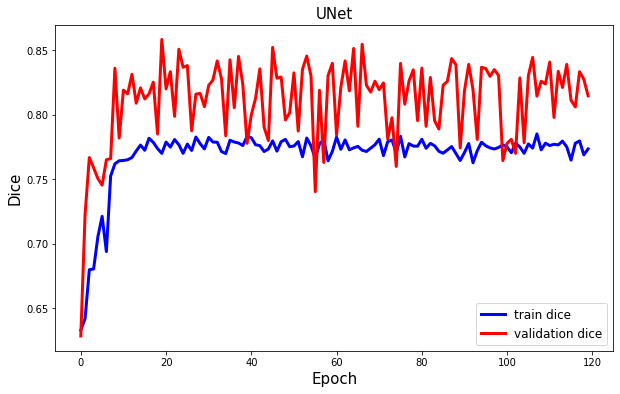

In [ ]:
#Train History

def plot_model_history(model_name, train_history, val_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="b")
    plt.plot(x, val_history, label='validation dice', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Dice", fontsize=15)

    plt.show()
    
plot_model_history('UNet', train_history, val_history, num_epochs)

In [ ]:
# Prediction

test_iou = compute_iou(model, test_dataloader)
print("Mean IoU: {:.3f}%".format(100*test_iou))


Mean IoU: 82.721%


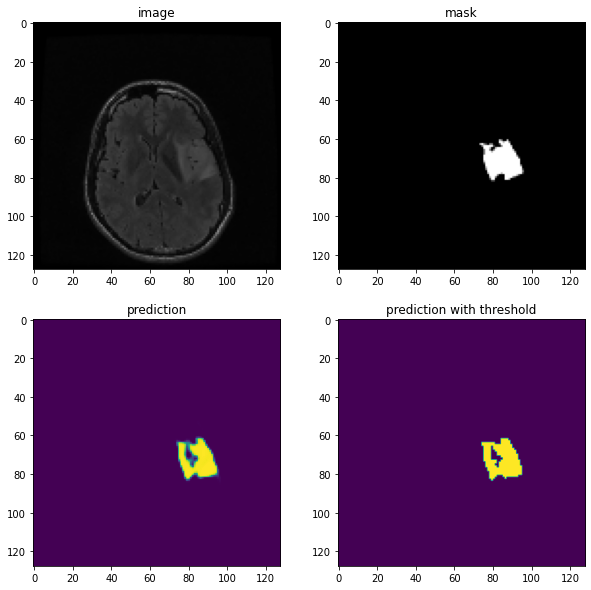

In [ ]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

In [ ]:
test_samples = test_df[test_df["diagnosis"] == 1].sample(105).values

def batch_preds_overlap(model, samples):
    """
    Computes prediction on the dataset
    
    Returns: list with images overlapping with predictions
    
    """
    prediction_overlap = []
    for test_sample in samples:

         # sample
        image = cv2.resize(cv2.imread(test_sample[0]),(128, 128))
        image =  image / 255.
        ground_truth = cv2.resize(cv2.imread(test_sample[1], 0), (128, 128)).astype("uint8")

        # pred
        prediction = torch.tensor(image).unsqueeze(0).permute(0,3,1,2)
        prediction = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(prediction)
        prediction = model(prediction.to(device).float())
        prediction = prediction.detach().cpu().numpy()[0,0,:,:]

        prediction[np.nonzero(prediction < 0.3)] = 0.0
        prediction[np.nonzero(prediction >= 0.3)] = 255.
        prediction = prediction.astype("uint8")

        # overlap 
        original_img = cv2.resize(cv2.imread(test_sample[0]),(128, 128))

        _, thresh_gt = cv2.threshold(ground_truth, 127, 255, 0)
        _, thresh_p = cv2.threshold(prediction, 127, 255, 0)
        contours_gt, _ = cv2.findContours(thresh_gt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours_p, _ = cv2.findContours(thresh_p, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        overlap_img = cv2.drawContours(original_img, contours_gt, 0, (0, 255, 0), 1)
        overlap_img = cv2.drawContours(overlap_img, contours_p, 0, (255,36,0), 1)#255,0,0
        prediction_overlap.append(overlap_img)

    return prediction_overlap
    
prediction_overlap_r = batch_preds_overlap(model, test_samples)

In [ ]:
pred_overlap_5x1_r = []
pred_overlap_5x3_r = []

for i in range(5, 105+5, 5):
    pred_overlap_5x1_r.append(np.hstack(np.array(prediction_overlap_r[i-5:i])))

for i in range(3, 21+3, 3):
    pred_overlap_5x3_r.append(np.vstack(pred_overlap_5x1_r[i-3:i]))

In [ ]:
def plot_plate_overlap(batch_preds, title, num):
    plt.figure(figsize=(15, 15))
    plt.imshow(batch_preds)
    plt.axis("off")

    plt.figtext(0.76,0.75,"Green - Ground Truth", va="center", ha="center", size=20,color="lime");
    plt.figtext(0.26,0.75,"Red - Prediction", va="center", ha="center", size=20, color="#ff0d00");
    plt.suptitle(title, y=.80, fontsize=20, weight="bold", color="#00FFDE");

    fn = "_".join((title+str(num)).lower().split()) + ".png"
    plt.savefig(fn, bbox_inches='tight', pad_inches=0.2, transparent=False, facecolor='black')
    plt.close()

title = "Predictions of UNet"

for num, batch in enumerate(pred_overlap_5x3_r):
    plot_plate_overlap(batch,title, num)
    

In [ ]:
from PIL import Image

def make_gif(title):
    base_name = "_".join(title.lower().split())

    base_len = len(base_name) 
    end_len = len(".png")
    fp_in = f"{base_name}*.png"
    fp_out = f"{base_name}.gif"

    img, *imgs = [Image.open(f) 
                  for f in sorted(glob.glob(fp_in), key=lambda x : int(x[base_len:-end_len]))]

    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=1000, loop=0)
    
    return fp_out

fn = make_gif(title)

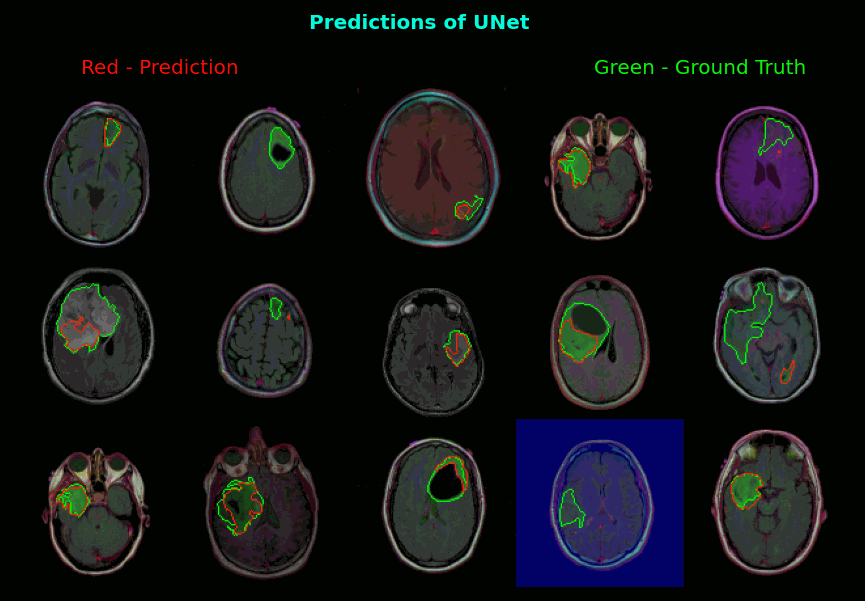

In [ ]:
from IPython.display import Image as Image_display
with open(fn,'rb') as f:
    display(Image_display(data=f.read(), format='png'))

In [ ]:
torch.save(model.state_dict(), 'unet-model.ckpt')